<h1>Programming Assignment-I</h1>
<h4>Canny Edge Detection Implementation</h4>

In [2]:
# Please uncomment the following line if you don't have the packages installed

#%pip install numpy Pillow matplotlib ipywidgets

In [3]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import PIL as pl
import ipywidgets as widgets

In [4]:
def read_image(filename):
    # read image as grayscale
    img = pl.Image.open(filename).convert('L')
    # convert to numpy array
    I = np.array(img)
    return I

In [5]:
# Read the image
image_path = 'test_image_1.jpg'
I = read_image(image_path)
I

array([[203, 203, 203, ..., 159, 158, 164],
       [203, 203, 203, ..., 160, 159, 163],
       [203, 203, 203, ..., 161, 161, 169],
       ...,
       [  6,  15,  10, ...,   4,   4,   3],
       [  7,  11,   1, ...,   4,   4,   3],
       [  4,   4,   4, ...,   5,   5,   5]], dtype=uint8)

In [6]:
# function to get guassian filter
def get_guassian_filter(I, sigma):
    # calculate length of filter by using rule of thumb: filter half-width to about 3 σ
    n = 3*sigma*2+1

    # create a nx1 Gaussian filter
    G = np.zeros((n,1))
    for i in range(1,n+1):
        G[i-1] = np.exp(-0.5*((i-(n+1)/2)/sigma)**2)
    
    return G

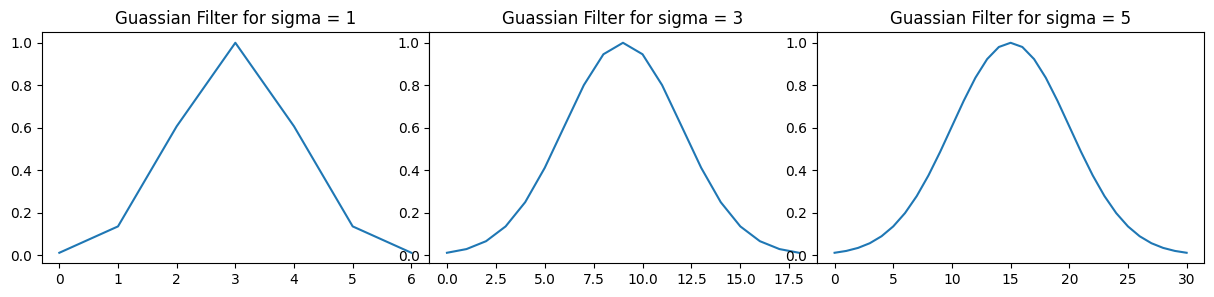

In [7]:
# initialize sigma
sigma = [1,3,5]

# get guassian filter for each sigma and plot them in one figure
fig, axs = plt.subplots(1,len(sigma), figsize=(15, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(len(sigma)):
    G = get_guassian_filter(I, sigma[i])
    axs[i].plot(G)
    axs[i].set_title('Guassian Filter for sigma = '+str(sigma[i]))

In [8]:
# function to get gaussian derivative filters
def get_guassian_derivatives(I, sigma):
    # calculate length of filter by using rule of thumb: filter half-width to about 3 σ
    n = 3*sigma*2+1

    # first derivative of Gaussian filter in y-direction
    Gy = np.zeros((n,1))
    for i in range(1,n+1):
        Gy[i-1] = -((i-(n+1)/2)/sigma**2)*np.exp(-0.5*((i-(n+1)/2)/sigma)**2)
    
    # first derivative of Gaussian filter in x-direction
    Gx = Gy.T
    
    return Gx, Gy

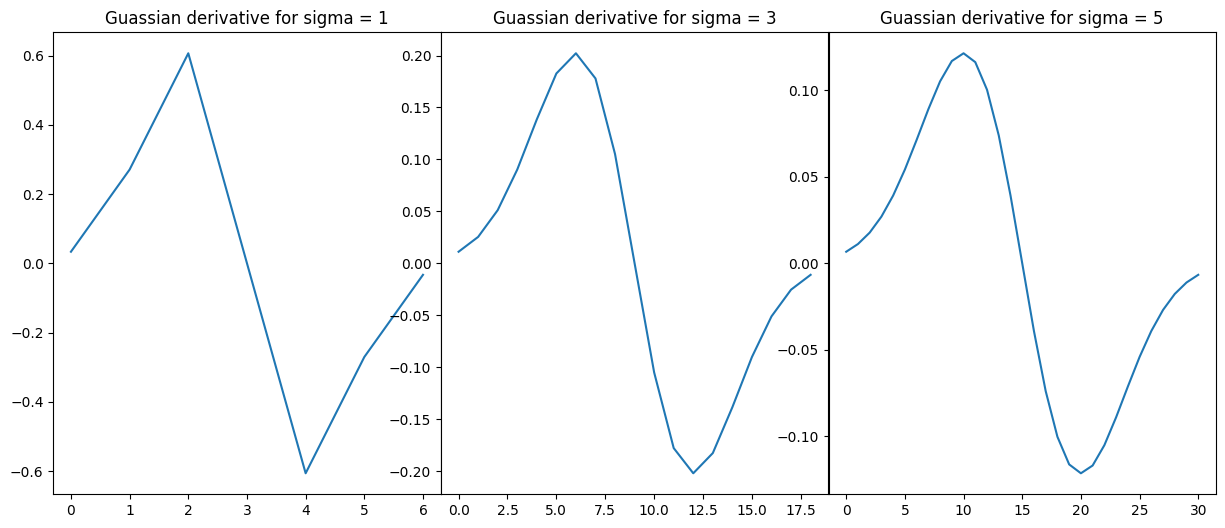

In [9]:
# for each sigma, get gaussian derivative filters and plot them in one figure
fig, axs = plt.subplots(1,len(sigma), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
Gx = []
Gy = []
for i in range(len(sigma)):
    Gx_temp, Gy_temp = get_guassian_derivatives(I, sigma[i])
    Gx.append(Gx_temp)
    Gy.append(Gy_temp)
    axs[i].plot(Gy_temp)
    axs[i].set_title('Guassian derivative for sigma = '+str(sigma[i]))


In [10]:
# function to add padding to image
def custom_padding(image, padding_size_rows, padding_size_columns):
    # increase the size of each dimension by twice the padding_size
    new_shape = (image.shape[0] + 2*padding_size_rows, image.shape[1] + 2*padding_size_columns)
    # create a new array of zeros with the new shape
    zeros = np.zeros(new_shape)
    # add the image to the center of the new array
    zeros[padding_size_rows:padding_size_rows+image.shape[0], padding_size_columns:padding_size_columns+image.shape[1]] = image
    return zeros

In [11]:
# function to calculate convolution of image with filter
def custom_convolution(image, filter):
    # get shape of input image
    [x,y] = image.shape

    # calculate padding size
    [m,n] = filter.shape
    padding_size_rows = int((m-1)/2)
    padding_size_columns = int((n-1)/2)
    # add padding to image
    image = custom_padding(image, padding_size_rows, padding_size_columns)

    # flip filter in both directions to get the correct convolution
    kernel = np.flipud(np.fliplr(filter))

    # convert image to columns
    expansion = image_2_col(image, (m,n))
    
    # calculate convolution    
    output = np.matmul(kernel.flatten(), expansion).reshape(x,y)
    return output

# function to convert image to columns for convolution through matrix multiplication
def image_2_col(img, filter_size, stride=1):
    [filter_rows,filter_columns] = filter_size
    [image_rows,image_columns] = img.shape

    # output image dimensions
    output_rows = int((image_rows - filter_rows)/stride + 1)
    output_columns = int((image_columns - filter_columns)/stride + 1)

    # find the index values of the pixels where kernel will be applied at start
    start_idx = np.reshape(np.arange(filter_rows), (filter_rows, 1)) * image_columns + np.arange(filter_columns)

    # find the offset values of the pixels where kernel will be applied at each step
    offset_idx = np.reshape(np.arange(output_rows), (output_rows, 1)) * image_columns*stride + np.arange(output_columns*stride)

    # add the offset values to the start values to get the index values of the pixels where kernel will be applied
    return np.take(img, np.reshape(start_idx.flatten(), (np.size(start_idx), 1)) + offset_idx.flatten()[::stride])

In [12]:
# function to apply guassian derivative filters to image
def apply_guassian_derivatives(I, Gx, Gy):
    
    # apply guassian derivative filters to image
    Ix = custom_convolution(I, Gx)
    Iy = custom_convolution(I, Gy)
    return Ix, Iy

In [13]:
# Apply guassian derivative filters to image
Ix = []
Iy = []
for i in range(len(sigma)):
    Ix_temp, Iy_temp = apply_guassian_derivatives(I, Gx[i], Gy[i])
    Ix.append(Ix_temp)
    Iy.append(Iy_temp)

In [14]:
# function to calculate magnitude of gradient
def calculate_magnitude(Ix, Iy):
    # calculate magnitude of gradient
    M = np.sqrt(Ix**2 + Iy**2)
    return M

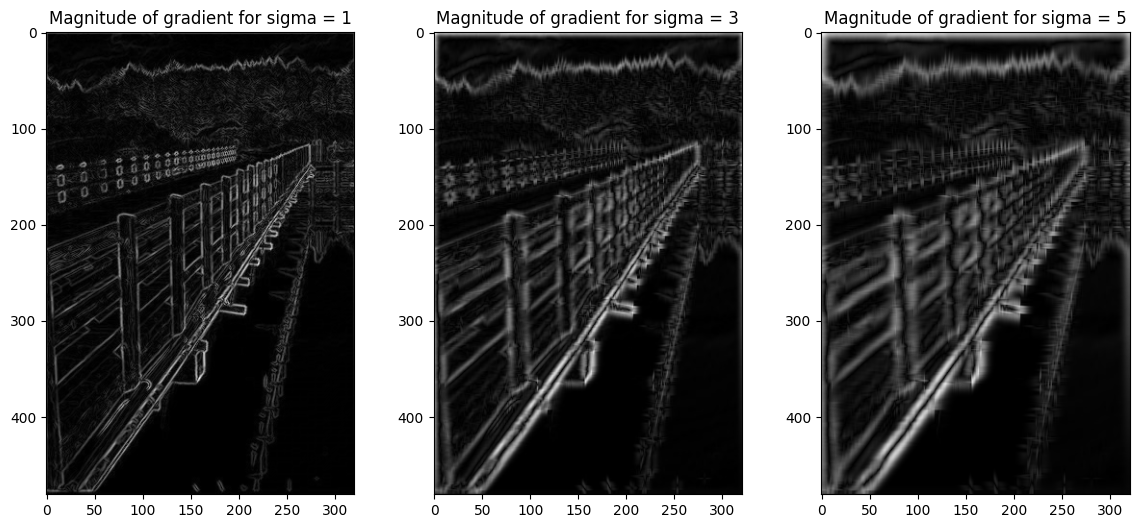

In [15]:
# calculate magnitude of gradient for each sigma and plot them in one figure
fig, axs = plt.subplots(1,len(sigma), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
M = []
for i in range(len(sigma)):
    M_temp = calculate_magnitude(Ix[i], Iy[i])
    M.append(M_temp)
    axs[i].imshow(M_temp, cmap='gray')
    axs[i].set_title('Magnitude of gradient for sigma = '+str(sigma[i]))

In [16]:
# function to calculate orientation of gradient
def calculate_orientation(Ix, Iy):
    # calculate orientation of gradient
    θ = np.arctan2(Iy, Ix)
    return θ

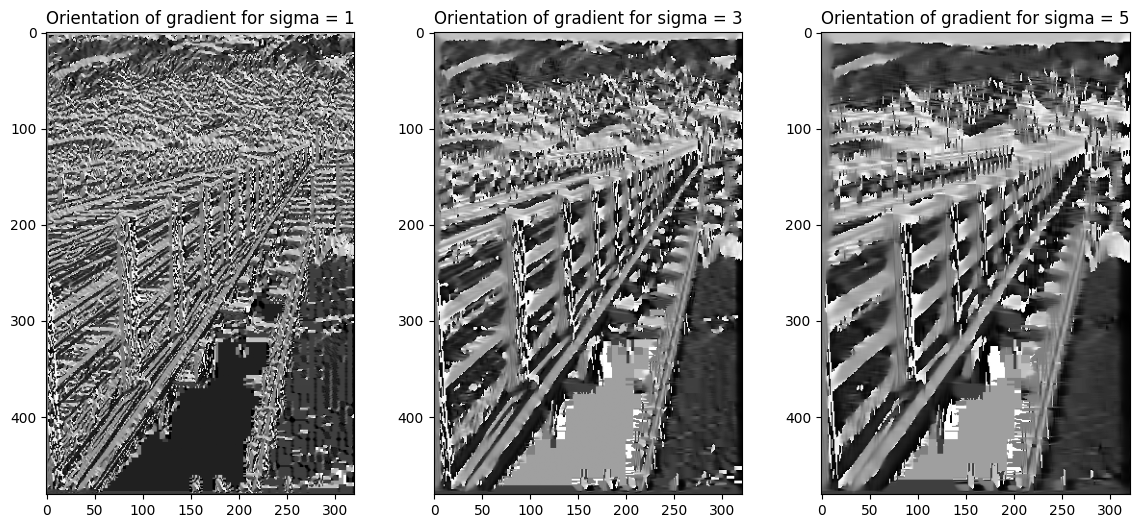

In [17]:
# calculate orientation of gradient for each sigma and plot them in one figure
fig, axs = plt.subplots(1,len(sigma), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
θ = []
for i in range(len(sigma)):
    θ_temp = calculate_orientation(Ix[i], Iy[i])
    θ.append(θ_temp)
    axs[i].imshow(θ_temp, cmap='gray')
    axs[i].set_title('Orientation of gradient for sigma = '+str(sigma[i]))

In [18]:
# non max suppression function with interpolation
def non_max_suppression_interpolation(M, θ):
    # Get shape of gradient magnitude matrix
    [l,w] = M.shape

    # Get the absolute value of the angle
    θ = np.abs(θ)

    # Pad gradient magnitude matrix with zeros to prevent error on edge cases
    M = custom_padding(M, 1, 1)

    for j in range(1,w+1):
        for i in range(1,l+1):
            if θ[i-1,j-1] == 0 or θ[i-1,j-1] == np.pi*2:           

                # Check if gradient value is greater than left and right gradient values else set it to 0
                M[i,j] = M[i,j] if ((M[i,j] > M[i,j+1]) and (M[i,j] > M[i,j-1])) else 0 

            if θ[i-1,j-1] == np.pi/4:            

                # Check if gradient value is greater than bottom-left and top-right gradient values else set it to 0
                M[i,j] = M[i,j] if ((M[i,j] > M[i-1,j+1]) and (M[i,j] > M[i+1,j-1])) else 0

            if θ[i-1,j-1] == np.pi/2:            

                # Check if gradient value is greater than bottom and top gradient values else set it to 0
                M[i,j] = M[i,j] if ((M[i,j] > M[i-1,j]) and (M[i,j] > M[i+1,j])) else 0 
            
            if θ[i-1,j-1] == np.pi*3/4:            

                # Check if gradient value is greater than bottom-right and top-left gradient values else set it to 0
                M[i,j] = M[i,j] if ((M[i,j] > M[i-1,j-1]) and (M[i,j] > M[i+1,j+1])) else 0

            if θ[i-1,j-1] > 0 and θ[i-1,j-1] < np.pi/4:           
                
                # Interpolate between top right and right pixels
                top_right = M[i,j+1]*(1-np.tan(θ[i-1,j-1])) + M[i-1,j+1]*(np.tan(θ[i-1,j-1]))

                # Interpolate between bottom left and left pixels
                bottom_left = M[i,j-1]*(1-np.tan(θ[i-1,j-1])) + M[i+1,j-1]*(np.tan(θ[i-1,j-1]))

                # Check if gradient value is greater than interpolated values
                M[i,j] = M[i,j] if ((M[i,j] > top_right) and (M[i,j] > bottom_left)) else 0

            if θ[i-1,j-1] > np.pi/4 and θ[i-1,j-1] < np.pi/2:

                # Interpolate between top right and top pixels
                top_right = M[i-1,j]*(1-np.tan(np.pi/2 - θ[i-1,j-1])) + M[i-1,j+1]*(np.tan(np.pi/2 - θ[i-1,j-1]))

                # Interpolate between bottom left and bottom pixels
                bottom_left = M[i+1,j]*(1-np.tan(np.pi/2 - θ[i-1,j-1])) + M[i+1,j-1]*(np.tan(np.pi/2 - θ[i-1,j-1]))

                # Check if gradient value is greater than interpolated values
                M[i,j] = M[i,j] if ((M[i,j] > top_right) and (M[i,j] > bottom_left)) else 0

            if θ[i-1,j-1] > np.pi/2 and θ[i-1,j-1] < np.pi*3/4:
                    
                # Interpolate between top left and top pixels
                top_left = M[i-1,j]*(1-np.tan(θ[i-1,j-1] - np.pi/2)) + M[i-1,j-1]*(np.tan(θ[i-1,j-1] - np.pi/2))

                # Interpolate between bottom right and bottom pixels
                bottom_right = M[i+1,j]*(1-np.tan(θ[i-1,j-1] - np.pi/2)) + M[i+1,j+1]*(np.tan(θ[i-1,j-1] - np.pi/2))

                # Check if gradient value is greater than interpolated values
                M[i,j] = M[i,j] if ((M[i,j] > top_left) and (M[i,j] > bottom_right)) else 0

            if θ[i-1,j-1] > np.pi*3/4 and θ[i-1,j-1] < np.pi:
                    
                # Interpolate between top left and left pixels
                top_left = M[i,j-1]*(1-np.tan(np.pi - θ[i-1,j-1])) + M[i-1,j-1]*(np.tan(np.pi - θ[i-1,j-1]))

                # Interpolate between bottom right and right pixels
                bottom_right = M[i,j+1]*(1-np.tan(np.pi - θ[i-1,j-1])) + M[i+1,j+1]*(np.tan(np.pi - θ[i-1,j-1]))

                # Check if gradient value is greater than interpolated values
                M[i,j] = M[i,j] if ((M[i,j] > top_left) and (M[i,j] > bottom_right)) else 0

    # remove zero padding
    M = M[1:-1, 1:-1]

    # normalize matrix to 0-255
    M/M.max() * 255

    return M

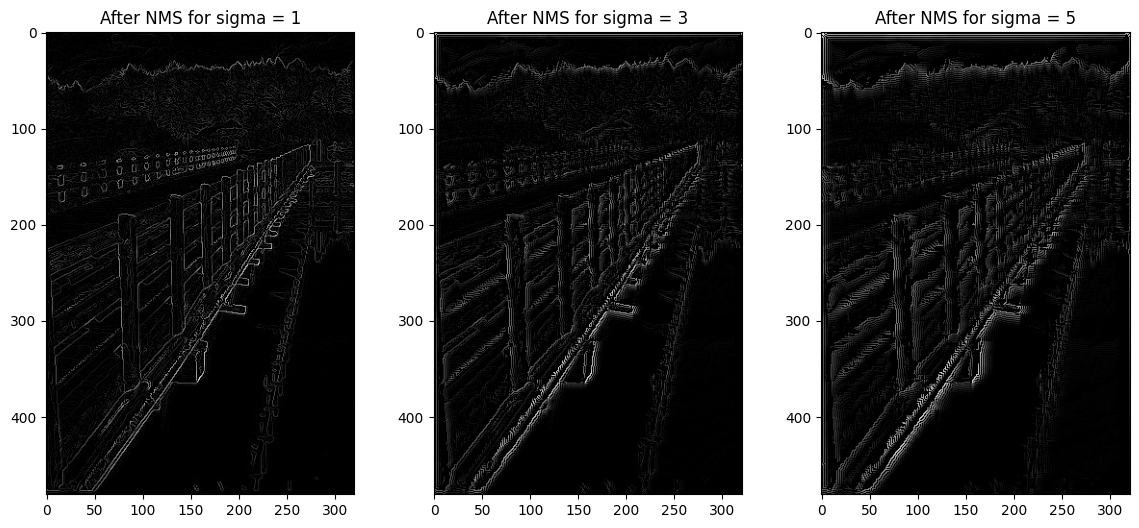

In [19]:
# For each M and θ, apply non-maximum suppression and display the results in a single plot
fig, axs = plt.subplots(1,len(sigma), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
S = []
for i in range(len(sigma)):
    S_temp = non_max_suppression_interpolation(M[i], θ[i])
    S.append(S_temp)
    axs[i].imshow(S_temp, cmap='gray')
    axs[i].set_title('After NMS for sigma = ' + str(sigma[i]))



In [20]:
# Hysterisis thresholding implementation
def hysteresis_thresholding(M, low_ratio, high_ratio):

    # get the high and low threshold values
    high_threshold = M.max() * high_ratio
    low_threshold = M.max() * low_ratio

    # pad the image with zeros
    padded_M = custom_padding(M, 1, 1)

    # get the number of rows and columns
    rows, cols = padded_M.shape

    # initialize final image
    final = np.zeros((rows, cols))

    # loop through the padded image
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # if the pixel value is greater than the high threshold, set it to 1
            if padded_M[i,j] > high_threshold:
                final[i,j] = 1
            # if the pixel value is less than the low threshold, set it to 0
            elif padded_M[i,j] < low_threshold:
                final[i,j] = 0
            # if the pixel value is between the high and low thresholds, check if it is connected to a pixel with value greater than the high threshold
            else:
                # set the pixel to 0.5 if it is between the high and low thresholds
                final[i,j] = 0.5

    # loop through the final image
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # if the pixel value is 1 check if any of the 8 connected pixels have value 0.5 and set them to 1
            if final[i,j] == 1:
                final = find_connected(final, i, j)

    # remove zero padding
    final = final[1:-1, 1:-1]

    # convert all 0.5 values to 0
    final[final == 0.5] = 0

    return final

# function to find connected pixels recursively
def find_connected(M, i, j):
    # check if any of the 8 connected pixels have value 0.5 and set them to 1
    if M[i-1,j-1] == 0.5:
        M[i-1,j-1] = 1

        # recursively call the function to check if any of the 8 connected pixels of the connected pixel have value 0.5 and set them to 1
        M = find_connected(M, i-1, j-1)
    if M[i-1,j] == 0.5:
        M[i-1,j] = 1
        M = find_connected(M, i-1, j)
    if M[i-1,j+1] == 0.5:
        M[i-1,j+1] = 1
        M = find_connected(M, i-1, j+1)
    if M[i,j-1] == 0.5:
        M[i,j-1] = 1
        M = find_connected(M, i, j-1)
    if M[i,j+1] == 0.5:
        M[i,j+1] = 1
        M = find_connected(M, i, j+1)
    if M[i+1,j-1] == 0.5:
        M[i+1,j-1] = 1
        M = find_connected(M, i+1, j-1)
    if M[i+1,j] == 0.5:
        M[i+1,j] = 1
        M = find_connected(M, i+1, j)
    if M[i+1,j+1] == 0.5:
        M[i+1,j+1] = 1
        M = find_connected(M, i+1, j+1)

    return M

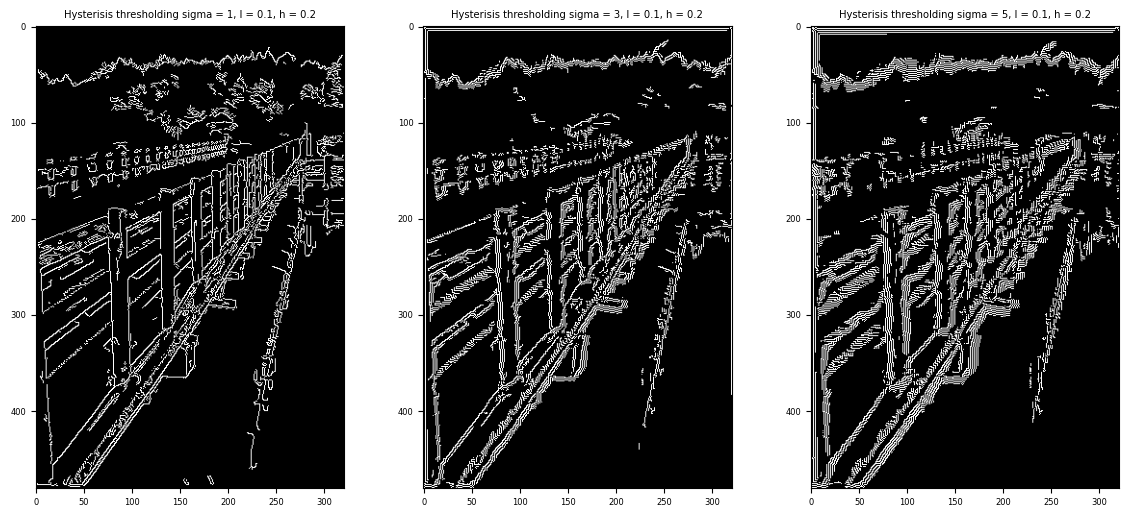

In [35]:
# For each M and θ, apply hysterisis thresholding and display the results in a single plot
fig, axs = plt.subplots(1,len(sigma), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
T = []
l = 0.1
h = 0.2
for i in range(len(sigma)):
    T_temp = hysteresis_thresholding(S[i], l, h)
    T.append(T_temp)
    axs[i].imshow(T_temp, cmap='gray')
    axs[i].set_title('Hysterisis thresholding sigma = ' + str(sigma[i]) + f', l = {l}, h = {h}')

In [33]:
# Final function to perform canny edge detection
def custom_canny(I, sigma, low_ratio, high_ratio):
    G = get_guassian_filter(I, sigma)
    Gx, Gy = get_guassian_derivatives(I, sigma)
    Ix, Iy = apply_guassian_derivatives(I, Gx, Gy)
    M = calculate_magnitude(Ix, Iy)
    θ = calculate_orientation(Ix, Iy)
    S = non_max_suppression_interpolation(M, θ)
    final = hysteresis_thresholding(S, low_ratio, high_ratio)

    # reduce title font size
    plt.rcParams.update({'font.size': 6})

    # plot the images side by side for comparison
    fig, axs = plt.subplots(3,3, figsize=(15, 15))
    axs[0,0].imshow(I, cmap='gray')
    axs[0,0].set_title('Original Image')
    axs[0,1].imshow(custom_convolution(I,G.T), cmap='gray')
    axs[0,1].set_title('X component of Gaussian convolution')
    axs[0,2].imshow(custom_convolution(I,G), cmap='gray')
    axs[0,2].set_title('Y component of Gaussian convolution')
    axs[1,0].imshow(Ix, cmap='gray')
    axs[1,0].set_title('X component of Gaussian derivative convolution')
    axs[1,1].imshow(Iy, cmap='gray')
    axs[1,1].set_title('Y component of Gaussian derivative convolution')
    axs[1,2].imshow(M, cmap='gray')
    axs[1,2].set_title('Gradient magnitude')
    axs[2,0].imshow(θ)
    axs[2,0].set_title('Gradient orientation')
    axs[2,1].imshow(S, cmap='gray')
    axs[2,1].set_title('Non max suppression')
    axs[2,2].imshow(final, cmap='gray')
    axs[2,2].set_title('Hysteresis thresholding')

In [34]:
I = read_image(image_path)

# interactive demo
widgets.interact(custom_canny, I=widgets.fixed(I), sigma=(1,7,1), low_ratio=(0.01, 1.0, 0.005), high_ratio=(0.0, 1.0, 0.005), continuous_update=False)

interactive(children=(IntSlider(value=4, description='sigma', max=7, min=1), FloatSlider(value=0.505, descript…

<function __main__.custom_canny(I, sigma, low_ratio, high_ratio)>